### Data Science in Practice Project
### Authors: Wen Yang, Yixin Huang

#### need to put the dwm.py in the same path with this jupyter notebook

In [6]:
import dwm ### this is the new emsemble classifier I've implemented
import river
import pandas as pd
from river.stream import iter_pandas
from river import datasets
from river import metrics
from river import utils
from river.utils import dict2numpy
from matplotlib.backends.backend_pdf import PdfPages
from scipy.io import arff

### this is an algorithm from [1]:
[1] Kolter and Maloof. Dynamic weighted majority: An ensemble method for drifting concepts. The Journal of Machine Learning Research, 8:2755-2790, December 2007. ISSN 1532-4435.


The dataset used in this algorithm can't be found anywhere on the internet, so we are not able to present the results in this paper.
But luckily, the skmultiflow library have the same algorithm, so we can use it as a baseline, and compare our result with skmultiflow.

# 1. The first dataset: Synthetic Data Stream with concept drift 
### Synthetic dataset
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/5OWRGB&version=1.0
López Lobo, Jesús, 2020, "Synthetic datasets for concept drift detection purposes", https://doi.org/10.7910/DVN/5OWRGB, Harvard Dataverse, V1, UNF:6:VVTBgRNMEV+B/GmoE3Myng== [fileUNF]
	
In order to know about the performance of a drift detector by measuring the different detection metrics, we need to know beforehand where a real drift occurs. This is only possible with synthetic datasets. The scikit-multiflow framework allows generating several kinds of synthetic data to simulate the occurrence of drifts.


## (1). we studied this dataset using River and the dynamic weighted majority classifier that we implemented
Comparing the results for (1)naive bayes (2) adwin bagging  (3) dwm 
Result ( Error rate) :  

(1)naive bayes 0.50 : NB does not learn this concept drift data stream

(2)adwin bagging 0.18: 

(3) dwm 0.13:  both adwin and new algo can improuve performance, new_algo performes better  in this case

Conclusion: 

 ensemble methods are more accurate to deal with data set with drift than a single learner
 possible explaination: this new algo's weight changes when drift comes, if a learner's making more error, its weight decrease
 at last it will be poped, and a new learner is going to be trained using new coming data

In [7]:
### Synthetic Data Stream
dataset2 = "mixed_0101_gradual"
df2 = pd.read_csv(dataset2+".csv")
label_col = df2.columns[-1]
feature_cols = list(df2.columns)
feature_cols.pop()
X = df2[feature_cols]
Y = df2[label_col].astype('int')
stream=iter_pandas(X=X, y=Y)

n_samples = 0
correct_cnt = 0
max_samples = df2.shape[0]

In [8]:
### Synthetic Data Stream
### Test the new dataset with NB, showing that NB is not good at predicting dataset with drifting
import pandas as pd
from river.stream import iter_pandas
from river import datasets
dataset2 = "mixed_0101_gradual"
df2 = pd.read_csv(dataset2+".csv")
label_col = df2.columns[-1]
feature_cols = list(df2.columns)
feature_cols.pop()
X = df2[feature_cols]
Y = df2[label_col].astype('int')
stream=iter_pandas(X=X, y=Y)

n_samples = 0
correct_cnt = 0
max_samples = df2.shape[0]

import pandas
from river import naive_bayes
naive_bayes2 = naive_bayes.BernoulliNB()


for x, y in stream:
    naive_bayes2.learn_one(x, y)
    y_pred = naive_bayes2.predict_one(x)

    if y == y_pred:
        correct_cnt += 1
    
    n_samples += 1

    if n_samples ==  max_samples:
        break
        
print('{} samples analyzed.'.format(n_samples))
print('Naive Bayes error rate: {}'.format( 1- correct_cnt / n_samples))
    
    
  

41000 samples analyzed.
Naive Bayes error rate: 0.4999268292682927


In [9]:
### Synthetic Data Stream
## test this new dataset with our new method
dataset2 = "mixed_0101_gradual"
df2 = pd.read_csv(dataset2+".csv")
label_col = df2.columns[-1]
feature_cols = list(df2.columns)
feature_cols.pop()
X = df2[feature_cols]
Y = df2[label_col].astype('int')
stream=iter_pandas(X=X, y=Y)

n_samples = 0
correct_cnt = 0
max_samples = df2.shape[0]

# from river import naive_bayes

naive_bayes2_test = dwm.DynamicWeightedMajorityClassifier_river(n_estimators=5, period= 500)


for x, y in stream:
    naive_bayes2_test.learn_one(x, y)
    y_pred = naive_bayes2_test.predict_one(x)
    
    if y == y_pred:
        correct_cnt += 1
        
    n_samples += 1

    if n_samples ==  max_samples:
        break
        
print('{} samples analyzed.'.format(n_samples))
print('DynamicWeightedMajority with Naive Bayes error rate: {}'.format(1-correct_cnt / n_samples))
    

41000 samples analyzed.
DynamicWeightedMajority with Naive Bayes error rate: 0.1329268292682927


In [10]:
### Synthetic Data Stream
### Test the new dataset with adwin, showing that adwin imporve the results, but our new algo performes better
import pandas as pd
from river.stream import iter_pandas
from river import datasets

dataset2 = "mixed_0101_gradual"
df2 = pd.read_csv(dataset2+".csv")
label_col = df2.columns[-1]
feature_cols = list(df2.columns)
feature_cols.pop()
X = df2[feature_cols]
Y = df2[label_col].astype('int')
stream=iter_pandas(X=X, y=Y)

n_samples = 0
correct_cnt = 0
max_samples = df2.shape[0]

import pandas
from river import ensemble
from river import naive_bayes
from river import linear_model
model = ensemble.ADWINBaggingClassifier(
     model=(
         
         linear_model.LogisticRegression()
     ),
     n_models=5,
     seed=42
 )


for x, y in stream:
    model.learn_one(x, y)
    y_pred = model.predict_one(x)

    if y == y_pred:
        correct_cnt += 1
    
    n_samples += 1

    if n_samples ==  max_samples:
        break
        
print('{} samples analyzed.'.format(n_samples))
print('adwin error rate: {}'.format( 1- correct_cnt / n_samples))
    
    
  

41000 samples analyzed.
adwin error rate: 0.19429268292682922


## (2). test our results using skmultiflow ( another open source library for steam learning), similar results has been produced, showing it a good performence of this dwm method, 
## The results means that we have correctly implemented this algorithm on river  
The results (error rates) for Synthetic Data Streams using skmultiflow:

(1) NB (already exist in this module) 0.50: not learning this drifted dataset

(2) Oza Adwin bagging (already exist in this module, we are using NB as a base_estimator) 0.25

(3) DWM (already exist in this module, defalt setting is NB as estimator) 0.13

In [12]:
### Synthetic Data Stream 
### skmultiflow
import skmultiflow
dataset2 = "mixed_0101_gradual"
df2 = pd.read_csv(dataset2+".csv")
label_col = df2.columns[-1]
feature_cols = list(df2.columns)
feature_cols.pop()
X = df2[feature_cols]
Y = df2[label_col].astype('int')
# stream=iter_pandas(X=X, y=Y)

n_samples = 0
correct_cnt = 0
max_samples = df2.shape[0]
stream = skmultiflow.data.FileStream(dataset2+".csv")
from skmultiflow.bayes import NaiveBayes
naive_bayes = NaiveBayes()

while n_samples < max_samples and stream.has_more_samples():
    
    X, y = stream.next_sample()
#     print(X.type)
    y_pred = naive_bayes.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    naive_bayes.partial_fit(X, y)
    n_samples += 1
print('{} samples analyzed.'.format(n_samples))
print('Naive Bayes error rate: {}'.format(1- correct_cnt / n_samples))

41000 samples analyzed.
Naive Bayes error rate: 0.5000487804878049


In [13]:
### Synthetic Data Stream 
### skmultiflow
import skmultiflow
dataset2 = "mixed_0101_gradual"
df2 = pd.read_csv(dataset2+".csv")
label_col = df2.columns[-1]
feature_cols = list(df2.columns)
feature_cols.pop()
X = df2[feature_cols]
Y = df2[label_col].astype('int')
classes_2 = list(Y.unique() )

max_samples = df2.shape[0]
stream = skmultiflow.data.FileStream(dataset2+".csv")

from skmultiflow.meta import OzaBaggingADWINClassifier
from skmultiflow.bayes import NaiveBayes
clf = OzaBaggingADWINClassifier(base_estimator=NaiveBayes(),
                                n_estimators=5)
n_samples = 0
correct_cnt = 0
max_samples = max_samples 

X, y = stream.next_sample(20)
clf = clf.partial_fit(X, y, classes=classes_2)
for i in range(max_samples-20):
    
    X, y = stream.next_sample()
    pred = clf.predict(X)
    clf = clf.partial_fit(X, y)
    if pred is not None:
        if y[0] == pred[0]:
            correct_cnt += 1
    n_samples += 1
print('{} samples analyzed.'.format(n_samples+20))
print('Oza Adwin baggin error rate: {}'.format(1-correct_cnt / n_samples))


41000 samples analyzed.
Oza Adwin baggin error rate: 0.25671059053196676


In [14]:
### Synthetic Data Stream 
### skmultiflow
import skmultiflow
dataset2 = "mixed_0101_gradual"
df2 = pd.read_csv(dataset2+".csv")
label_col = df2.columns[-1]
feature_cols = list(df2.columns)
feature_cols.pop()
X = df2[feature_cols]
Y = df2[label_col].astype('int')
# stream=iter_pandas(X=X, y=Y)

n_samples = 0
correct_cnt = 0
max_samples = df2.shape[0]
stream = skmultiflow.data.FileStream(dataset2+".csv")




from skmultiflow.meta import DynamicWeightedMajorityClassifier
dwm_skm = DynamicWeightedMajorityClassifier(n_estimators=5, period= 500)
n_samples = 0
correct_cnt = 0
max_samples = max_samples 
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = dwm_skm.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    dwm_skm.partial_fit(X, y)
    n_samples += 1
print('{} samples analyzed.'.format(n_samples))
print('Dynamic Weighted Majority error rate: {}'.format(1-correct_cnt / n_samples))


41000 samples analyzed.
Dynamic Weighted Majority error rate: 0.13478048780487806


# 2. The second dataset: Real world electricity dataset
### Electricity dataset
https://moa.cms.waikato.ac.nz/datasets/
Electricity is another widely used dataset described by M. Harries and analysed by Gama. This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. The ELEC dataset contains 45, 312 instances. (The class label identifies the change of the price relative to a moving average of the last 24 hours.)
Electricity contains 45,312 instances, with 8 input attributes, recorded every half an hour for two years from Australian New South Wales Electricity. The classification task is to predict a rise (Up) or a fall (Down) in the electricity price. The concept drift may happen because of changes in consumption habits, unexpected events, and seasonality .

## (1) Compare the results of Naive Bayes and Dynamic Weighted Majority 
Result:

(1) Naive bayes: Accurayy = 0.732

(2) Dynamic weighted majority classifier Accurayy = 0.788

Conclusions: 
DWM improves the performance of classification, on this real world dataset, the drift is not too much significant, a single naive bayes has alredy performed well, so the improvement on this dataset is not as good as the synthetic dataset, but we still see an improvement for this Dynamic weighted majority classifier

In [15]:
dataset = "elec"
df = pd.read_csv("./data/"+dataset+".csv")
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]
## define the data stream
stream=iter_pandas(X=X, y=Y)
n_samples = 0
correct_cnt = 0
max_samples = df.shape[0]
from river import naive_bayes
naive_bayes_river_elec = naive_bayes.GaussianNB()
for x, y in stream:
    naive_bayes_river_elec .learn_one(x, y)
    y_pred = naive_bayes_river_elec .predict_one(x)
    
    if y == y_pred:
        correct_cnt += 1
        
    n_samples += 1

    if n_samples ==  max_samples:
        break
        
print('{} samples analyzed.'.format(n_samples))
print('River Naive Bayes accuracy: {}'.format(correct_cnt / n_samples))
    

45311 samples analyzed.
River Naive Bayes accuracy: 0.7321621681269449


In [16]:
dataset = "elec"
df = pd.read_csv("./data/"+dataset+".csv")
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]
## define the data stream
stream=iter_pandas(X=X, y=Y)
n_samples = 0
correct_cnt = 0
max_samples = df.shape[0]
# from river import naive_bayes
naive_bayes2_test = dwm.DynamicWeightedMajorityClassifier_river(n_estimators=5, period= 100)
for x, y in stream:
    naive_bayes2_test.learn_one(x, y)
    y_pred = naive_bayes2_test.predict_one(x)
    
    if y == y_pred:
        correct_cnt += 1
        
    n_samples += 1

    if n_samples ==  max_samples:
        break
        
print('{} samples analyzed.'.format(n_samples))
print('DynamicWeightedMajority with Naive Bayes accuracy: {}'.format(correct_cnt / n_samples))
    

45311 samples analyzed.
DynamicWeightedMajority with Naive Bayes accuracy: 0.7881309174372669


## (2). Study how different value of chunk_size ( that is the number of x-y pairs to train a learner in this dwm algo)
 Results:
 
 Accuracy decrease when chunk_size increase.
 
 This is a real dataset containning drift.
 
 large chunk_size => lower performence to detecte the drift in the data, and then will lead to bad performance
 
 We can imagine that if chunk_size = max_sample_number, only one learner will be trained, than it is not emsemble of learners, it becomes a single learner


In [17]:

dataset = "elec"
df = pd.read_csv("./data/"+dataset+".csv")
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]
stream=iter_pandas(X=X, y=Y)


In [18]:

def evaluate(n_estimators,chunk_size):

    from river import naive_bayes
    naive_bayes2_test = dwm.DynamicWeightedMajorityClassifier_river(n_estimators=n_estimators, period= chunk_size)
    n_samples = 0
    correct_cnt = 0
    max_samples = df.shape[0]

    for x, y in stream:
        naive_bayes2_test.learn_one(x, y)
        y_pred = naive_bayes2_test.predict_one(x)

        if y == y_pred:
            correct_cnt += 1

        n_samples += 1

        if n_samples ==  max_samples:
            break
    print("n_estimator= ", n_estimators, "chunk size = ", chunk_size)
    print('{} samples analyzed.'.format(n_samples))
    print('DynamicWeightedMajority accuracy: {}'.format(correct_cnt / n_samples))



In [19]:
Chunk_size = [50,100,500,1000,1500,2000]
for i in Chunk_size:
    stream=iter_pandas(X=X, y=Y)
    evaluate(n_estimators=5, chunk_size = i)

n_estimator=  5 chunk size =  50
45311 samples analyzed.
DynamicWeightedMajority accuracy: 0.8130034649422877
n_estimator=  5 chunk size =  100
45311 samples analyzed.
DynamicWeightedMajority accuracy: 0.7881309174372669
n_estimator=  5 chunk size =  500
45311 samples analyzed.
DynamicWeightedMajority accuracy: 0.748449603848955
n_estimator=  5 chunk size =  1000
45311 samples analyzed.
DynamicWeightedMajority accuracy: 0.7535256339520204
n_estimator=  5 chunk size =  1500
45311 samples analyzed.
DynamicWeightedMajority accuracy: 0.7521352430977025
n_estimator=  5 chunk size =  2000
45311 samples analyzed.
DynamicWeightedMajority accuracy: 0.7476992341815453


### (3) Study the accuracy and kappa score for naive bayes, adwin bagging and dynamic weighted majority
Results:

(1) Emsemble methods (adwin bagging and dynamic weighted majority)  can improve performance of a single learner ( naive bayes).

(2) Dynamic weighted majority performs best in our test.

(3) We strongly recommend emsemble methods when dealing with data streams with drift


In [23]:

def print_progress(sample_id, acc, kappa):
    print(f'Samples processed: {sample_id}')
    print(acc)
    print(kappa)

def evaluate_acc_kappa(stream, model, n_wait=1000, verbose=False):
    from river import metrics
    acc = metrics.Accuracy()
    acc_rolling = metrics.Rolling(metric=metrics.Accuracy(), window_size=n_wait)
    # acc_rolling = utils.Rolling(metrics.Accuracy(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    # kappa_rolling = utils.Rolling(metrics.CohenKappa(), window_size=n_wait)
    kappa_rolling = metrics.Rolling(metric=metrics.CohenKappa(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    for i, (x, y) in enumerate(stream):
        # Learn (train)
        model.learn_one(x, y)
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        acc.update(y_true=y, y_pred=y_pred)
        acc_rolling.update(y_true=y, y_pred=y_pred)
        kappa.update(y_true=y, y_pred=y_pred)
        kappa_rolling.update(y_true=y, y_pred=y_pred)
        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, acc, kappa)
            raw_results.append([model_name, i, acc.get(), acc_rolling.get(), kappa.get(), kappa_rolling.get()])
        
    print_progress(i, acc, kappa)
    return pd.DataFrame(raw_results, columns=['model', 'id', 'acc', 'acc_roll', 'kappa', 'kappa_roll'])


In [24]:
from river import naive_bayes
from river import ensemble
from river import linear_model



dataset = "elec"
df = pd.read_csv("./data/"+dataset+".csv")
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]
print("evaluate the naive bayes classifier")
naive_bayes_river = naive_bayes.GaussianNB()
nb_river_results = evaluate_acc_kappa(stream=iter_pandas(X=X, y=Y),
                      model=naive_bayes_river)
print("evaluate the Dynamic-Weighted-Majority classifier")
dwm_test = dwm.DynamicWeightedMajorityClassifier_river(n_estimators=5, period= 50)
dwm_test_result = evaluate_acc_kappa(stream=iter_pandas(X=X, y=Y),
                      model=dwm_test)
print("evaluate the Adwin Bagging classifier")
adwin_model = ensemble.ADWINBaggingClassifier(
     model=(naive_bayes.GaussianNB()
     ),
     n_models=5,
     seed=42
 )
adwin_result = evaluate_acc_kappa(stream=iter_pandas(X=X, y=Y),
                      model=adwin_model)

evaluate the naive bayes classifier
Samples processed: 45310
Accuracy: 73.22%
CohenKappa: 41.96%
evaluate the Dynamic-Weighted-Majority classifier
Samples processed: 45310
Accuracy: 81.30%
CohenKappa: 61.26%
evaluate the Adwin Bagging classifier
Samples processed: 45310
Accuracy: 78.69%
CohenKappa: 55.21%


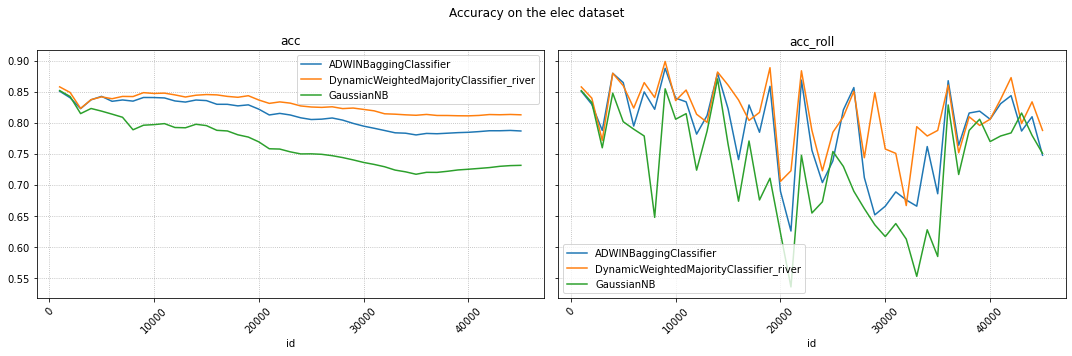

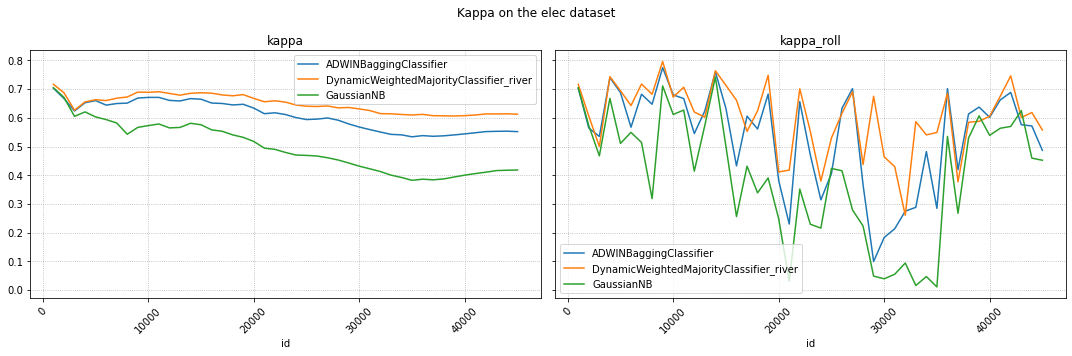

In [28]:
## plot figure
import matplotlib.pyplot as plt
dataset = "elec"

# df = pd.concat([adaboost_results, ht_results, bagging_results])
df = pd.concat([ nb_river_results,dwm_test_result,adwin_result])
df.set_index('id', inplace=True)
grouped = df.groupby('model')

with PdfPages(f'results_{dataset}.pdf') as pdf:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['acc', 'acc_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)

        ax.grid(linestyle=':')
    fig.suptitle("Accuracy on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['kappa', 'kappa_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)

        ax.grid(linestyle=':')
    fig.suptitle("Kappa on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page

### multi-class classification using covertype dataset
Covertype dataset with 7 classes: Contains the forest cover type for 30 x 30 meter cells obtained from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. It contains 581, 012 instances and 54 attributes, and it has been used in several papers on data stream classification.

Predicted attribute: cover type 1 to 7 
Could only accept numerical types as class. 
When dealing with catagories using the dynamic weight majority method, we need calculate "y_pred * weight" in order to get the most possible pedicted Y, so Y must be a number, not a catagory

### Reults (accuracy rate):
Our code: 0.71

naive_bayes: 0.49


In [29]:

## test covertype dataset with nb
import pandas
from river import naive_bayes
df2 = pd.read_table("covtype.data",header =None,sep=",")

# dataset2 = "iris-shuffled-numerical"
# df2 = pd.read_csv(dataset2+".csv")
label_col = df2.columns[-1]
feature_cols = list(df2.columns)
feature_cols.pop()
X = df2[feature_cols]
Y = df2[label_col].astype('int')
stream=iter_pandas(X=X, y=Y)
n_samples = 0
correct_cnt = 0
max_samples = df2.shape[0]
nb = naive_bayes.GaussianNB()
cnt = 0
for x, y in stream:
#     print(cnt)
    cnt+=1
    nb.learn_one(x, y)
    y_pred = nb.predict_one(x)
    if y == y_pred:
        correct_cnt += 1        
    n_samples += 1
    if n_samples ==  max_samples:
        break        
print('{} samples analyzed.'.format(n_samples))
print('Naive Bayes accuracy: {}'.format(correct_cnt / n_samples))


581012 samples analyzed.
Naive Bayes accuracy: 0.4877300296723648


In [30]:
### Covertype Dataset Data Stream 
## test this  our dwm method
df2 = pd.read_table("covtype.data",header =None,sep=",")

# dataset2 = "iris-shuffled-numerical"
# df2 = pd.read_csv(dataset2+".csv")
label_col = df2.columns[-1]
feature_cols = list(df2.columns)
feature_cols.pop()
X = df2[feature_cols]
Y = df2[label_col].astype('int')
stream=iter_pandas(X=X, y=Y)
n_samples = 0
correct_cnt = 0
max_samples = df2.shape[0]
dwm_multi = dwm.DynamicWeightedMajorityClassifier_river(n_estimators=2, period= 50)
cnt = 0
for x, y in stream:
#     print(cnt)
    cnt+=1
    dwm_multi.learn_one(x, y)
    y_pred = dwm_multi.predict_one(x)
    if y == y_pred:
        correct_cnt += 1        
    n_samples += 1
    if n_samples ==  max_samples:
        break        
print('{} samples analyzed.'.format(n_samples))
print('DynamicWeightedMajority with Naive Bayes accuracy: {}'.format(correct_cnt / n_samples))


581012 samples analyzed.
DynamicWeightedMajority with Naive Bayes accuracy: 0.7061076191197428
